In [1]:
#Imports and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.decomposition import PCA
import time
from scipy import stats
import shap
from shap import sample

C:\Users\trilo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Task 1: Data Preprocessing and Exploration
print("\n=== Task 1: Data Preprocessing and Exploration ===")


=== Task 1: Data Preprocessing and Exploration ===


Time taken for loading the dataset is 0.4603238105773926 seconds

Performing EDA...

Missing Values: 0

Visualizing feature distributions before outlier removal...


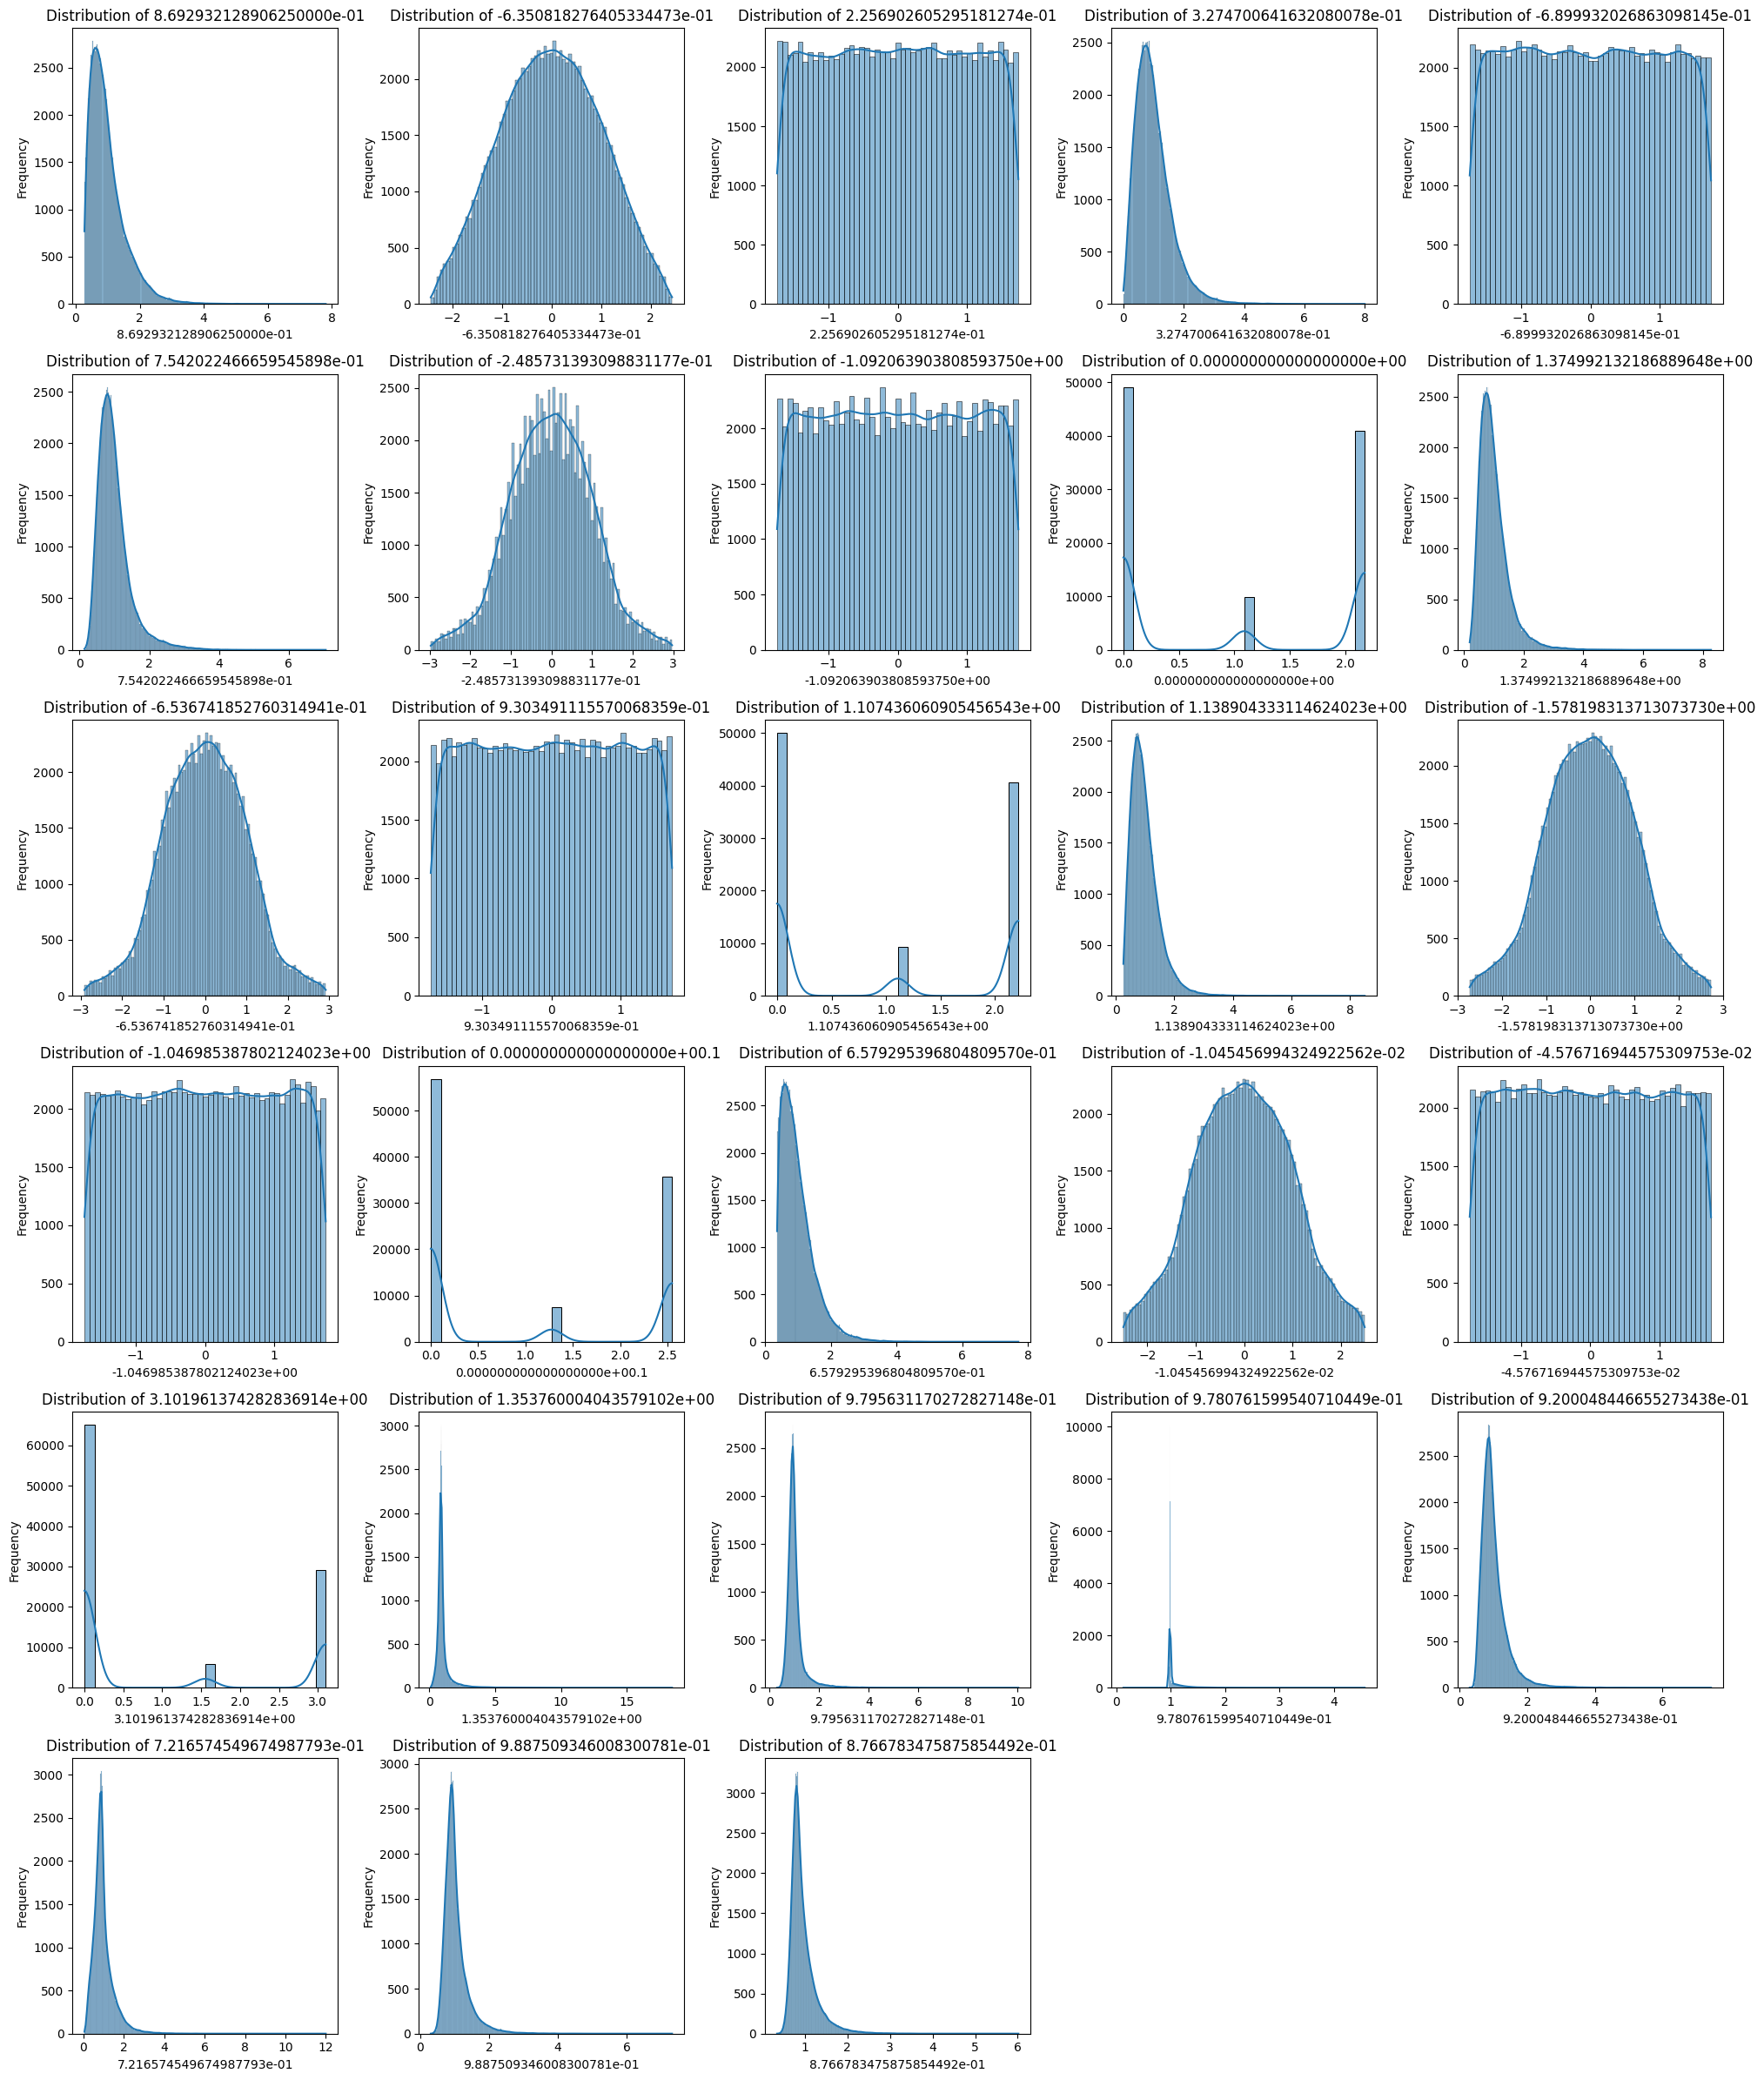

Dataset shape before outlier removal: (100000, 28)
Dataset shape after outlier removal: (45295, 28)

Visualizing feature distributions after outlier removal...


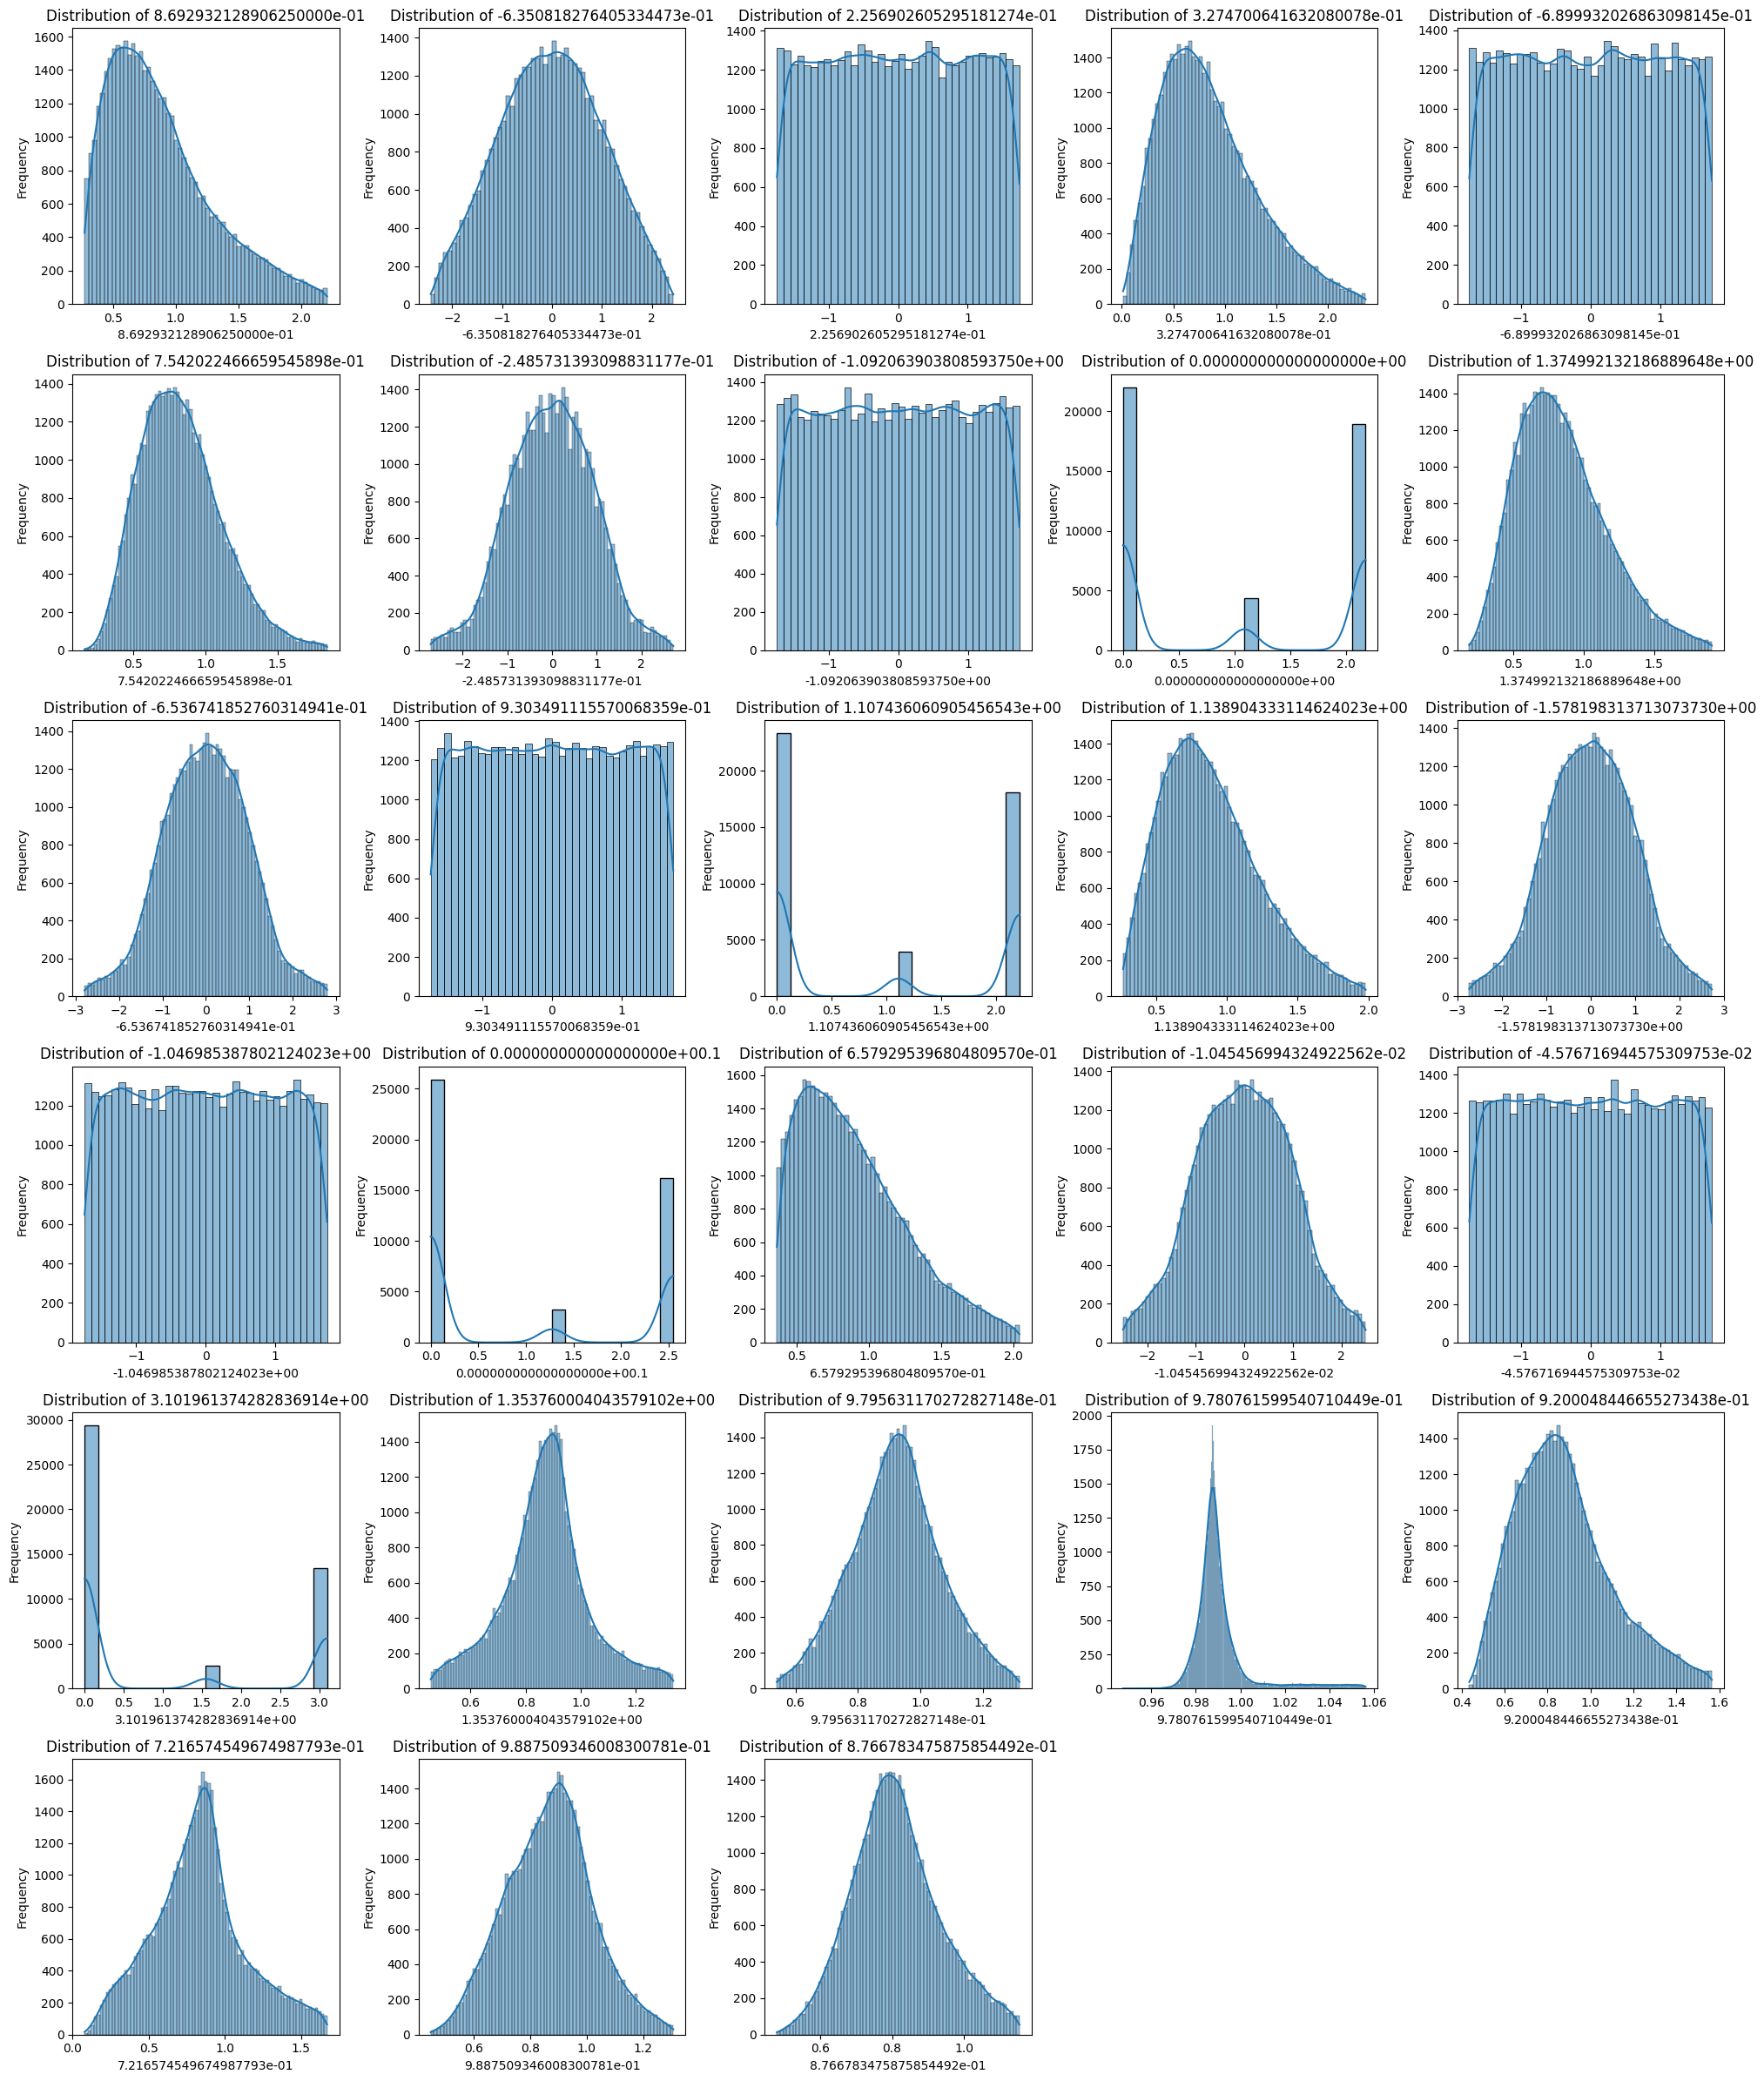


Performing data normalization...

Performing feature engineering...
Adding interaction terms...
Features after engineering: 41

Performing feature selection with SelectKBest...

Top features selected by SelectKBest: ['-6.350818276405334473e-01', '2.256902605295181274e-01', '-6.899932026863098145e-01', '0.000000000000000000e+00', '-6.536741852760314941e-01', '1.107436060905456543e+00', '-1.046985387802124023e+00', '0.000000000000000000e+00.1', '-4.576716944575309753e-02', '3.101961374282836914e+00', '1.353760004043579102e+00', '9.780761599540710449e-01', '9.200048446655273438e-01', '7.216574549674987793e-01', '8.766783475875854492e-01', '8.692932128906250000e-01_squared', '-6.350818276405334473e-01_squared', '-6.350818276405334473e-01_cubic', '2.256902605295181274e-01_squared', '-6.899932026863098145e-01_squared']
                             Feature     Score
10         -6.536741852760314941e-01  6.815835
31   -6.350818276405334473e-01_cubic  6.760436
16        0.000000000000000000e+0

In [3]:
# Load the dataset
start_time = time.time()
data = pd.read_csv('HIGGS.csv', nrows=100000)
time_taken = time.time() - start_time
print(f"Time taken for loading the dataset is {time_taken} seconds")

# Separate features and target
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# 1.1 Exploratory Data Analysis
print("\nPerforming EDA...")
print("\nMissing Values:", X.isnull().sum().sum())

# Visualize feature distributions before outlier removal
print("\nVisualizing feature distributions before outlier removal...")
plt.figure(figsize=(20, 24))  # Adjusted to fit all 29 subplots
for i, col in enumerate(X.columns, 1):
    plt.subplot(6, 5, i)  # 6 rows, 5 columns grid to accommodate 29 features
    sns.histplot(X[col], kde=True)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Remove Outliers using IQR method
def remove_outliers_iqr(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

print("Dataset shape before outlier removal:", X.shape)
X = remove_outliers_iqr(X, X.columns)
X.reset_index(drop=True, inplace=True)
y = y[X.index]
y.reset_index(drop=True, inplace=True)
print("Dataset shape after outlier removal:", X.shape)

# Visualize feature distributions after outlier removal
print("\nVisualizing feature distributions after outlier removal...")
plt.figure(figsize=(20, 24))
for i, col in enumerate(X.columns, 1):
    plt.subplot(6, 5, i)
    sns.histplot(X[col], kde=True)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# 1.2 Data Normalization
print("\nPerforming data normalization...")
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# 1.3 Feature Engineering
print("\nPerforming feature engineering...")
# Polynomial features for first 5 features
for i in range(5):
    col_name = X.columns[i]
    X_scaled[f"{col_name}_squared"] = X_scaled[col_name] ** 2
    X_scaled[f"{col_name}_cubic"] = X_scaled[col_name] ** 3

# Interaction terms between pairs of important features
print("Adding interaction terms...")
for i in range(3):
    for j in range(i+1, 3):
        col1, col2 = X.columns[i], X.columns[j]
        X_scaled[f"{col1}_{col2}_interaction"] = X_scaled[col1] * X_scaled[col2]

print(f"Features after engineering: {X_scaled.shape[1]}")


# 1.4 Feature Selection using SelectKBest
print("\nPerforming feature selection with SelectKBest...")
k_best = SelectKBest(score_func=f_classif, k=20)
X_selected_kb = k_best.fit_transform(X_scaled, y)
selected_features_kb = X_scaled.columns[k_best.get_support()].tolist()

print("\nTop features selected by SelectKBest:", selected_features_kb)
feature_scores = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Score': k_best.scores_
})
print(feature_scores.nlargest(10, 'Score'))

In [4]:
# Task 2: Linear SVM Implementation
print("\n=== Task 2: Linear SVM Implementation ===")


=== Task 2: Linear SVM Implementation ===


In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_kb, y, test_size=0.2, random_state=42
)


# Linear SVM with cross-validation
print("\nTraining Linear SVM with cross-validation...")
start_time = time.time()
# Initialize the LinearSVC model
linear_svm = LinearSVC(random_state=42, dual=False)
cv_scores = cross_val_score(linear_svm, X_train, y_train, cv=5)
# Cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
print(f"Time taken for cross-validation: {time.time() - start_time:.2f} seconds")
# Train the final model on the full training data
print("\nTraining final Linear SVM model on the full training set...")
linear_svm.fit(X_train, y_train)
# Predictions and evaluation
y_pred = linear_svm.predict(X_test)
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# ROC AUC calculation
# LinearSVC doesn't directly provide probabilities, using decision function instead for ROC AUC
y_scores = linear_svm.decision_function(X_test)
roc_auc = roc_auc_score(y_test, y_scores)
# Printing key metrics
print("\nLinear SVM Performance Metrics on Test Set:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC (Area Under the ROC Curve): {roc_auc:.3f}")
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))



# Scalability and Efficiency with SGDClassifier (Stochastic Gradient Descent for SVM)
print("\nTraining SVM using SGDClassifier for large-scale data...")
start_time = time.time()
# Initialize SGDClassifier for linear SVM with mini-batch learning
sgd_svm = SGDClassifier(loss="hinge", random_state=42, max_iter=1000, tol=1e-3)
# Cross-validation scores using SGD
sgd_cv_scores = cross_val_score(sgd_svm, X_train, y_train, cv=5)
print(f"SGD Cross-validation scores: {sgd_cv_scores}")
print(f"Mean SGD CV score: {sgd_cv_scores.mean():.3f} (+/- {sgd_cv_scores.std() * 2:.3f})")
print(f"Time taken for cross-validation: {time.time() - start_time:.2f} seconds")
# Train the final model on the full training data
print("\nTraining final Linear SGD model on the full training set...")
# Training on full training set
sgd_svm.fit(X_train, y_train)
y_pred_sgd = sgd_svm.predict(X_test)
# Calculating metrics for SGD-based model
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
precision_sgd = precision_score(y_test, y_pred_sgd)
recall_sgd = recall_score(y_test, y_pred_sgd)
f1_sgd = f1_score(y_test, y_pred_sgd)
roc_auc_sgd = roc_auc_score(y_test, sgd_svm.decision_function(X_test))
print("\nSGD SVM Performance Metrics on Test Set:")
print(f"Accuracy: {accuracy_sgd:.3f}")
print(f"Precision: {precision_sgd:.3f}")
print(f"Recall: {recall_sgd:.3f}")
print(f"F1 Score: {f1_sgd:.3f}")
print(f"AUC (Area Under the ROC Curve): {roc_auc_sgd:.3f}")
print(f"Time taken for SGD-based SVM training: {time.time() - start_time:.2f} seconds")
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Training Linear SVM with cross-validation...
Cross-validation scores: [0.52993929 0.52987443 0.53222023 0.53070236 0.53097834]
Mean CV score: 0.531 (+/- 0.002)
Time taken for cross-validation: 0.44 seconds

Training final Linear SVM model on the full training set...

Linear SVM Performance Metrics on Test Set:
Accuracy: 0.531
Precision: 0.531
Recall: 0.993
F1 Score: 0.692
AUC (Area Under the ROC Curve): 0.512

Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.01      0.02      4256
         1.0       0.53      0.99      0.69      4803

    accuracy                           0.53      9059
   macro avg       0.53      0.50      0.35      9059
weighted avg       0.53      0.53      0.38      9059


Training SVM using SGDClassifier for large-scale data...
SGD Cross-validation scores: [0.53076711 0.51593763 0.51897337 0.53097834 0.5313923 ]
Mean SGD CV score: 0.526 (+/- 0.013)
Time taken for cross-validation: 0.55 seconds

Traini

In [6]:
# Task 3: SVM with Multiple Kernels
print("\n=== Task 3: Kernel SVM Implementation ===")


=== Task 3: Kernel SVM Implementation ===


In [7]:
# Generate sample data (replace with your data)
X, y = make_classification(n_samples=1000, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Helper function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.decision_function(X_test))
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

# Define SVM function for training with different kernels
def train_svm_with_kernel(kernel, param_grid, kernel_params=None):
    print(f"Training SVM with {kernel} kernel...")
    svm = SVC(kernel=kernel, **(kernel_params if kernel_params else {}))
    grid_search = GridSearchCV(svm, param_grid, scoring='f1', cv=5)
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    best_svm = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Training time: {train_time:.2f} seconds")
    
    # Prediction timing
    start_predict_time = time.time()
    evaluate_model(best_svm, X_test, y_test)
    predict_time = time.time() - start_predict_time
    print(f"Prediction time: {predict_time:.2f} seconds")
    print("\n")
    return train_time, predict_time

   

# Polynomial Kernel SVM
degrees = [2, 3, 4]
for degree in degrees:
    print(f"for degree : {degree}")
    train_svm_with_kernel('poly', {'C': [0.1, 1, 10]}, kernel_params={'degree': degree})

# RBF Kernel SVM
gammas = [0.01, 0.1, 1, 10]
train_svm_with_kernel('rbf', {'C': [0.1, 1, 10], 'gamma': gammas})

# Custom Kernel (Sigmoid Kernel)
train_svm_with_kernel('sigmoid', {'C': [0.1, 1, 10]})

# Custom Kernel (Hybrid of RBF and Linear Kernel)
def hybrid_kernel(X, Y):
    return np.dot(X, Y.T) + np.exp(-0.1 * np.linalg.norm(X[:, np.newaxis] - Y, axis=2)**2)

svm_hybrid = SVC(kernel=hybrid_kernel)
grid_search_hybrid = GridSearchCV(svm_hybrid, {'C': [0.1, 1, 10]}, scoring='f1', cv=5)
start_time = time.time()
grid_search_hybrid.fit(X_train, y_train)
train_time = time.time() - start_time

best_hybrid_svm = grid_search_hybrid.best_estimator_
print(f"\nBest parameters for Hybrid Kernel: {grid_search_hybrid.best_params_}")
print(f"Training time for Hybrid Kernel: {train_time:.2f} seconds")

# Prediction timing for hybrid kernel
start_predict_time = time.time()
evaluate_model(best_hybrid_svm, X_test, y_test)
predict_time = time.time() - start_predict_time
print(f"Prediction time for Hybrid Kernel: {predict_time:.2f} seconds")


for degree : 2
Training SVM with poly kernel...
Best parameters: {'C': 10}
Training time: 0.23 seconds
Accuracy: 0.4900, Precision: 0.5070, Recall: 0.4645, F1: 0.4848, AUC: 0.4934
Prediction time: 0.01 seconds


for degree : 3
Training SVM with poly kernel...
Best parameters: {'C': 1}
Training time: 0.11 seconds
Accuracy: 0.8233, Precision: 0.8643, Recall: 0.7806, F1: 0.8203, AUC: 0.8923
Prediction time: 0.01 seconds


for degree : 4
Training SVM with poly kernel...
Best parameters: {'C': 10}
Training time: 0.16 seconds
Accuracy: 0.5700, Precision: 0.5956, Recall: 0.5226, F1: 0.5567, AUC: 0.5914
Prediction time: 0.01 seconds


Training SVM with rbf kernel...
Best parameters: {'C': 1, 'gamma': 0.01}
Training time: 0.90 seconds
Accuracy: 0.8467, Precision: 0.8811, Recall: 0.8129, F1: 0.8456, AUC: 0.9161
Prediction time: 0.03 seconds


Training SVM with sigmoid kernel...
Best parameters: {'C': 1}
Training time: 0.11 seconds
Accuracy: 0.8467, Precision: 0.8759, Recall: 0.8194, F1: 0.8467, 

In [8]:
# Task 4: Hyperparameter Tuning
print("\n=== Task 4: Hyperparameter Tuning ===")


=== Task 4: Hyperparameter Tuning ===



Hyperparameter Tuning with Randomized Search and Bayesian Optimization

Tuning RBF Kernel with Bayesian Optimization...
Best parameters (RBF Kernel): OrderedDict([('C', 74.88174047459994), ('gamma', 0.0004869521028037488)])
Training time: 18.33 seconds
RBF Kernel Performance Metrics: (0.8533333333333334, 0.8881118881118881, 0.8193548387096774, 0.8523489932885906, 0.914794215795328)

Tuning Polynomial Kernel with Randomized Search...
Best parameters (Polynomial Kernel): {'degree': 3, 'C': 0.46415888336127775}
Training time: 2.98 seconds
Polynomial Kernel Performance Metrics: (0.82, 0.8854961832061069, 0.7483870967741936, 0.8111888111888111, 0.8978865406006673)

Sensitivity Analysis for RBF Kernel (C and gamma)


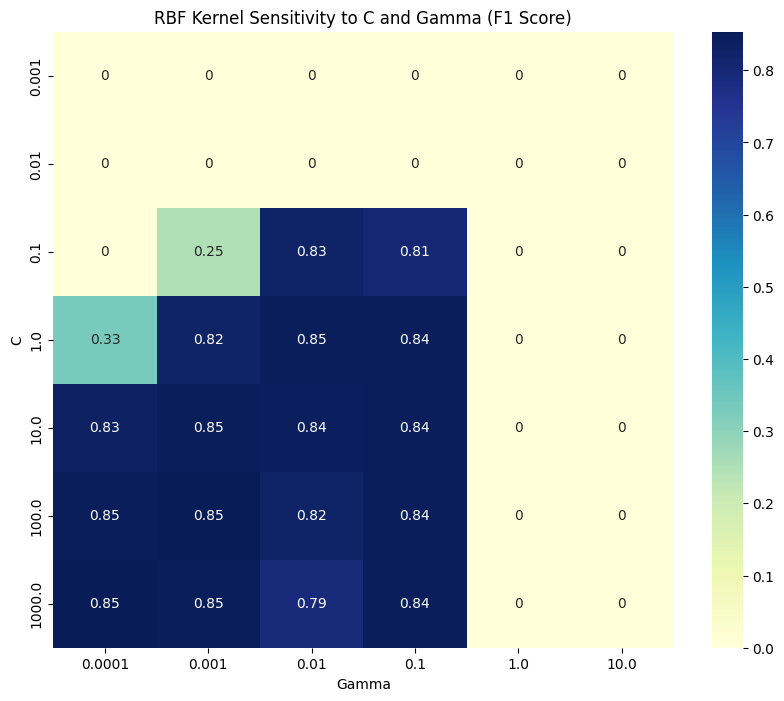


Sensitivity Analysis for Polynomial Kernel (C and degree)


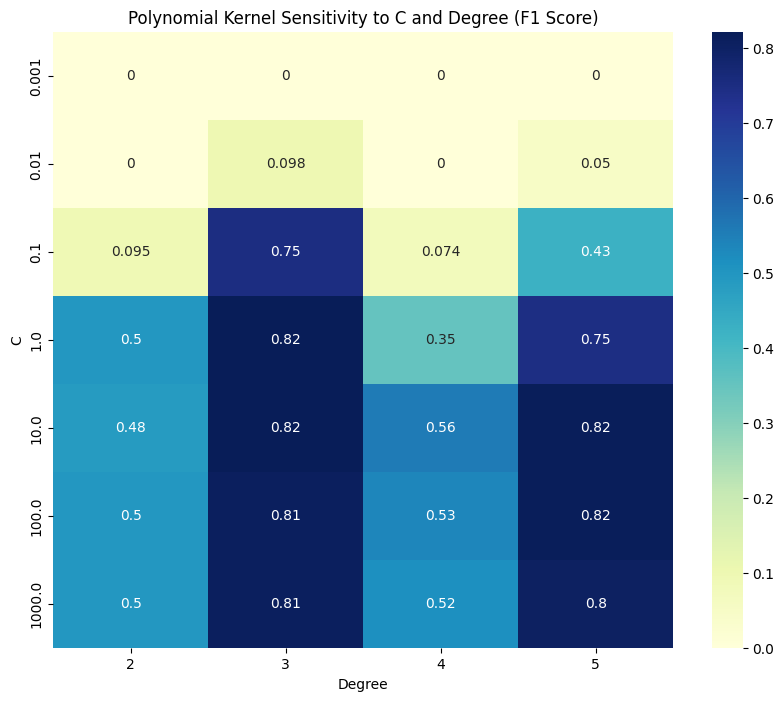

In [9]:
# Placeholder function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.decision_function(X_test))
    return accuracy, precision, recall, f1, auc

# 4.1 Hyperparameter Tuning with Randomized Search and Bayesian Optimization
print("\nHyperparameter Tuning with Randomized Search and Bayesian Optimization")

# Define parameter distributions for Randomized Search and Bayesian Optimization
param_distributions = {
    'C': np.logspace(-3, 3, 10),
    'gamma': np.logspace(-4, 1, 10),  # Applicable for RBF kernel
    'degree': [2, 3, 4, 5]            # Applicable for Polynomial kernel
}

# Tuning for RBF Kernel using Bayesian Optimization
print("\nTuning RBF Kernel with Bayesian Optimization...")
rbf_svm = SVC(kernel="rbf", probability=True)
rbf_bayes_search = BayesSearchCV(rbf_svm, {
    'C': (1e-3, 1e3, 'log-uniform'),
    'gamma': (1e-4, 1, 'log-uniform')
}, n_iter=20, scoring='f1', cv=5, random_state=42)
start_time = time.time()
rbf_bayes_search.fit(X_train, y_train)
train_time = time.time() - start_time
best_rbf_svm = rbf_bayes_search.best_estimator_
print(f"Best parameters (RBF Kernel): {rbf_bayes_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Evaluate the RBF model on the test set
rbf_results = evaluate_model(best_rbf_svm, X_test, y_test)
print("RBF Kernel Performance Metrics:", rbf_results)

# Tuning for Polynomial Kernel using Randomized Search
print("\nTuning Polynomial Kernel with Randomized Search...")
poly_svm = SVC(kernel="poly", probability=True)
poly_random_search = RandomizedSearchCV(poly_svm, {
    'C': param_distributions['C'],
    'degree': param_distributions['degree']
}, n_iter=20, scoring='f1', cv=5, random_state=42)
start_time = time.time()
poly_random_search.fit(X_train, y_train)
train_time = time.time() - start_time
best_poly_svm = poly_random_search.best_estimator_
print(f"Best parameters (Polynomial Kernel): {poly_random_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Evaluate the Polynomial model on the test set
poly_results = evaluate_model(best_poly_svm, X_test, y_test)
print("Polynomial Kernel Performance Metrics:", poly_results)

# 4.2 Hyperparameter Sensitivity Analysis and Visualization

# Define a range of C values and degrees/gammas for sensitivity analysis
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-4, 1, 6)
degree_range = [2, 3, 4, 5]

# Sensitivity Analysis for RBF Kernel on varying C and gamma
print("\nSensitivity Analysis for RBF Kernel (C and gamma)")
rbf_scores = []
for C in C_range:
    row = []
    for gamma in gamma_range:
        model = SVC(kernel="rbf", C=C, gamma=gamma)
        model.fit(X_train, y_train)
        f1 = f1_score(y_test, model.predict(X_test))
        row.append(f1)
    rbf_scores.append(row)

# Plot heatmap for RBF kernel sensitivity to C and gamma
plt.figure(figsize=(10, 8))
sns.heatmap(rbf_scores, annot=True, xticklabels=gamma_range, yticklabels=C_range, cmap="YlGnBu")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.title("RBF Kernel Sensitivity to C and Gamma (F1 Score)")
plt.show()

# Sensitivity Analysis for Polynomial Kernel on varying C and degree
print("\nSensitivity Analysis for Polynomial Kernel (C and degree)")
poly_scores = []
for C in C_range:
    row = []
    for degree in degree_range:
        model = SVC(kernel="poly", C=C, degree=degree)
        model.fit(X_train, y_train)
        f1 = f1_score(y_test, model.predict(X_test))
        row.append(f1)
    poly_scores.append(row)

# Plot heatmap for Polynomial kernel sensitivity to C and degree
plt.figure(figsize=(10, 8))
sns.heatmap(poly_scores, annot=True, xticklabels=degree_range, yticklabels=C_range, cmap="YlGnBu")
plt.xlabel("Degree")
plt.ylabel("C")
plt.title("Polynomial Kernel Sensitivity to C and Degree (F1 Score)")
plt.show()

In [10]:
# Task 5: Analysis and Report
print("\n=== Task 5: Final Analysis and Report ===")


=== Task 5: Final Analysis and Report ===



Performance Summary for Different Kernels
       Kernel  Accuracy  Precision    Recall  F1-Score       AUC  \
0      Linear  0.856667   0.878378  0.838710  0.858086  0.914171   
1  Polynomial  0.823333   0.864286  0.780645  0.820339  0.892325   
2         RBF  0.843333   0.864865  0.825806  0.844884  0.900067   
3      Custom  0.510000   0.528571  0.477419  0.501695  0.493081   

   Training Time (s)  Prediction Time (s)  
0           0.051785             0.004506  
1           0.025061             0.010127  
2           0.070375             0.033388  
3           8.756082             0.010692  

Analysis and Recommendations:
Best Kernel based on F1-Score: Linear
Performance Metrics:
Kernel                   Linear
Accuracy               0.856667
Precision              0.878378
Recall                  0.83871
F1-Score               0.858086
AUC                    0.914171
Training Time (s)      0.051785
Prediction Time (s)    0.004506
Name: 0, dtype: object

Explainability and Interpr

100%|██████████| 100/100 [05:28<00:00,  3.29s/it]


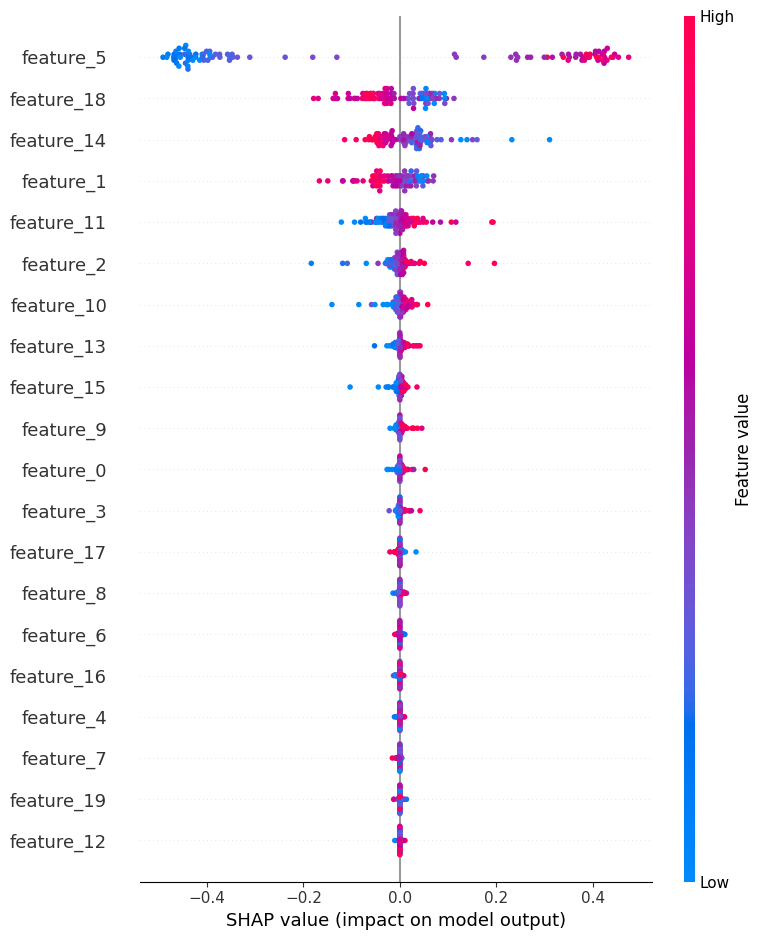


SHAP Analysis Complete: Feature importances and local explanations have been plotted.


In [11]:
# Train and evaluate models with each kernel, and store results and timing information

# Linear Kernel
start_time = time.time()
linear_svm = SVC(kernel='linear', probability=True)
linear_svm.fit(X_train, y_train)
linear_train_time = time.time() - start_time

start_time = time.time()
linear_results = evaluate_model(linear_svm, X_test, y_test)
linear_predict_time = time.time() - start_time

# Polynomial Kernel
start_time = time.time()
poly_svm = SVC(kernel='poly', degree=3, probability=True)  # Set degree as per tuning
poly_svm.fit(X_train, y_train)
poly_train_time = time.time() - start_time

start_time = time.time()
poly_results = evaluate_model(poly_svm, X_test, y_test)
poly_predict_time = time.time() - start_time

# RBF Kernel
start_time = time.time()
rbf_svm = SVC(kernel='rbf', gamma=0.1, probability=True)  # Set gamma as per tuning
rbf_svm.fit(X_train, y_train)
rbf_train_time = time.time() - start_time

start_time = time.time()
rbf_results = evaluate_model(rbf_svm, X_test, y_test)
rbf_predict_time = time.time() - start_time

# Custom Kernel
# Define a custom kernel function if applicable
def custom_kernel(X, Y):
    return np.dot(X, Y.T) ** 2  # Example custom kernel (can be modified)

start_time = time.time()
custom_svm = SVC(kernel=custom_kernel, probability=True)
custom_svm.fit(X_train, y_train)
custom_train_time = time.time() - start_time

start_time = time.time()
custom_results = evaluate_model(custom_svm, X_test, y_test)
custom_predict_time = time.time() - start_time

# Summary DataFrame for performance metrics
results_summary = {
    "Kernel": ["Linear", "Polynomial", "RBF", "Custom"],
    "Accuracy": [linear_results[0], poly_results[0], rbf_results[0], custom_results[0]],
    "Precision": [linear_results[1], poly_results[1], rbf_results[1], custom_results[1]],
    "Recall": [linear_results[2], poly_results[2], rbf_results[2], custom_results[2]],
    "F1-Score": [linear_results[3], poly_results[3], rbf_results[3], custom_results[3]],
    "AUC": [linear_results[4], poly_results[4], rbf_results[4], custom_results[4]],
    "Training Time (s)": [linear_train_time, poly_train_time, rbf_train_time, custom_train_time],
    "Prediction Time (s)": [linear_predict_time, poly_predict_time, rbf_predict_time, custom_predict_time]
}

# Convert to DataFrame for easy display
results_df = pd.DataFrame(results_summary)
print("\nPerformance Summary for Different Kernels")
print(results_df)

# Interpretation
print("\nAnalysis and Recommendations:")
best_kernel = results_df.loc[results_df['F1-Score'].idxmax()]
print(f"Best Kernel based on F1-Score: {best_kernel['Kernel']}")
print(f"Performance Metrics:\n{best_kernel}")

# Selecting the best model based on results summary
if best_kernel["Kernel"] == "Linear":
    best_model = linear_svm
elif best_kernel["Kernel"] == "Polynomial":
    best_model = poly_svm
elif best_kernel["Kernel"] == "RBF":
    best_model = rbf_svm
else:
    best_model = custom_svm

# Reduce the background data samples for SHAP's KernelExplainer
background_data = shap.sample(X_train, 100)  # Limiting to 100 samples to speed up

# 5.2 Explainability and Interpretability with SHAP
print("\nExplainability and Interpretability with SHAP")

# SHAP analysis for interpretability
explainer = shap.KernelExplainer(best_model.predict, background_data)
shap_values = explainer.shap_values(X_test[:100])  # Limiting to a sample due to computational cost

# Plot summary of SHAP values
shap.summary_plot(shap_values, X_test[:100], feature_names=[f'feature_{i}' for i in range(X_test.shape[1])])

# Display individual feature importance for a specific prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test[0, :])

print("\nSHAP Analysis Complete: Feature importances and local explanations have been plotted.")
